## 회귀(DNN: 전결합층)
- 하나의 수치 예측 모델 제작
- x: 광고 비용
- y: 매출액    

In [ ]:
# Matplotlib 축 이름 한글 깨짐의 방지
# Colab Ubuntu 20을 사용하며 메모리상에서 학습이 진행됨으로 ipynb를 닫으면,
# 다음 실행시 한글 폰트를 다시 설치해야함.
!fc-list # 폰트 목록

/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf: Liberation Sans Narrow:style=Italic
/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf: Liberation Sans:style=Regular
/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf: Liberation Mono:style=Bold Italic
/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf: Liberation Serif:style=Italic
/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf: Liberation Mono:style=Bold
/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf: Liberation Sans Narrow:style=Regular
/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf: Liberation Serif:style=Bold
/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf: Liberation Mono:style=Regular
/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf: Liberation Sans:style=Italic
/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf: Liberation Serif:style=Bold Italic
/usr/share/fonts/truet

In [ ]:
# 실행 런타임(CPU/GPU) 확인후 설치, 세션 초기화되면 재설치, GPU
# Matplotlib등의 시각화 패키지의 한글 처리
!sudo apt-get install -y fonts-nanum # 나눔고딕 설치
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 폰트 설치후 [런타임 -> 런타임 다시 시작]해야 한글이 인식됨, 설치된 폰트, 마운트 정보는 유지됨.

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (9,305 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 122541 files and di

In [1]:
import os
os.getcwd()

'c:\\workspace\\ai_with_conda\\script'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
# import cv2
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/dnn/click' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 10          # 글자 크기
plt.rcParams["figure.figsize"] = (6, 3) # 인치 단위 크기, width, height
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
    
# ---------------------------------------------------------------------

pd.set_option('display.max_columns', None) 

Matplotlib is building the font cache; this may take a moment.


In [3]:
data = np.loadtxt('../data/click.csv', delimiter=',', skiprows=1, dtype=np.float64)
print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(20, 2)


In [4]:
print(data[:3,:])

[[235. 591.]
 [216. 539.]
 [148. 413.]]


In [5]:
# y = ax + b
# 독립 변수 x
x_train = data[:, 0] 
print(x_train)

[235. 216. 148.  35.  85. 204.  49.  25. 173. 191. 134.  99. 117. 112.
 162. 272. 159. 159.  59. 198.]


In [6]:
# 종속 변수 y
y_train = data[:, 1]
print(y_train)

[591. 539. 413. 310. 308. 519. 325. 332. 498. 498. 392. 334. 385. 387.
 425. 659. 400. 427. 319. 522.]


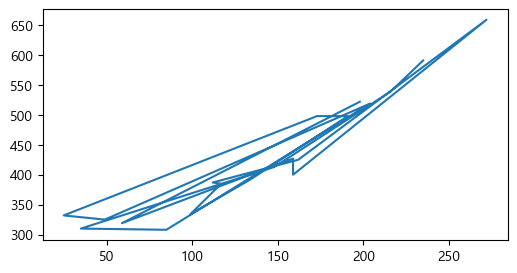

In [7]:
# 데이터 분포
plt.plot(x_train, y_train)
plt.show()

In [8]:
print(x_train)
idx = data[:, 0].argsort() # 값을 정렬한 후 해당 값의 index 추출, 원본 변경 안됨
print(f'idx: {idx}')       # 25, 35, 49 
print(data[idx])           # 이미 정렬된 index값에 따라 값이 출력됨.

[235. 216. 148.  35.  85. 204.  49.  25. 173. 191. 134.  99. 117. 112.
 162. 272. 159. 159.  59. 198.]
idx: [ 7  3  6 18  4 11 13 12 10  2 17 16 14  8  9 19  5  1  0 15]
[[ 25. 332.]
 [ 35. 310.]
 [ 49. 325.]
 [ 59. 319.]
 [ 85. 308.]
 [ 99. 334.]
 [112. 387.]
 [117. 385.]
 [134. 392.]
 [148. 413.]
 [159. 427.]
 [159. 400.]
 [162. 425.]
 [173. 498.]
 [191. 498.]
 [198. 522.]
 [204. 519.]
 [216. 539.]
 [235. 591.]
 [272. 659.]]


In [9]:
print(data[idx][::-1]) # 내림 차순

[[272. 659.]
 [235. 591.]
 [216. 539.]
 [204. 519.]
 [198. 522.]
 [191. 498.]
 [173. 498.]
 [162. 425.]
 [159. 400.]
 [159. 427.]
 [148. 413.]
 [134. 392.]
 [117. 385.]
 [112. 387.]
 [ 99. 334.]
 [ 85. 308.]
 [ 59. 319.]
 [ 49. 325.]
 [ 35. 310.]
 [ 25. 332.]]


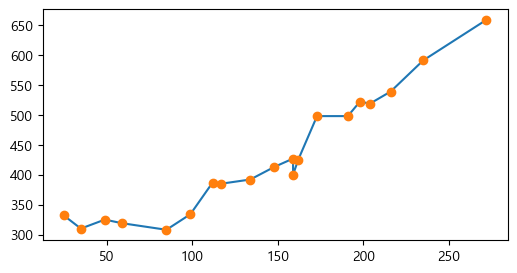

In [10]:
ds = data[idx]
x_train = ds[:, 0]
y_train = ds[:, 1]
plt.plot(x_train, y_train)
plt.plot(x_train, y_train, 'o')
plt.show()

### node(뉴런) 1개 사용하는 경우

In [18]:
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

model = Sequential()
# 1: 뉴런의 수, input_dim=1: 입력 데이터의 수, x의 개수, 
# linear: 활성화 함수, 회귀 연산을 변형하지 않고 출력함, 생략 가능, 
# name='layer1': 레이어의 이름, 생략 가능
model.add(Dense(1, input_dim=1, activation='linear', name='layer1'))
# optimizer='adam': 실제 값과 비교하여 오차를 산출후 오차가 감소되는 방향으로
# 가중치와 편향을 감소 시키는 최적화 함수(알고리즘)
# loss='mse': 찾아야할 목표값과의 차이를 제곱하여 합을 구한후 평균을 산출
# 오차가 적어지는 방향으로 가중치와 편향을 변경함.
model.compile(optimizer='adam', loss='mse')
model.summary()
# x_train: 훈련 데이터, 독립 변수
# y_train: 훈련 데이터, 종속 변수
# validation_split=0.2: 검증 20%, 20~30%
# shuffle=True: 데이터를 섞어서 사용
# epochs=10: 전체 데이터를 10번만 사용
# batch_size=1: 1건씩 읽어서 오차를 구한후 가중치(기울기)와 편향(y 절편)을 변경
hist = model.fit(x_train, y_train, validation_split=0.2, shuffle=True,
                epochs=10, batch_size=1)
# Epoch 1/10: 전체 데이터 횟수
# 16/16 [==============================] - 3s 15ms/step - loss: 238497.2969 - val_loss: 553888.2500
# 16/16: (전체데이터 - 검증(validation) 데이터 20%) / batch_size
# (20 - 4) / 1 = 16(최적화 횟수, 가중치와 편향을 변경하는 횟수, 오차 역전파 횟수)
# 전체 최적화 횟수: epochs * 최적화 횟수
# 10 * 16 = 160 번 가중치와 편향을 변경합니다.

# 배치사이즈: 2로 가정
# (20 - 4) / 2 = 8(최적화 횟수, 가중치와 편향을 변경하는 횟수, 오차 역전파 횟수)
# 전체 최적화 횟수: epochs * 최적화 횟수
# 10 * 8 = 80 번 가중치와 편향을 변경합니다.

# 검증시에는 가중치와 편향을 변경하지 않습니다.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
16/16 [==============================] - 1s 36ms/step - loss: 152334.7969 - val_loss: 317565.7500
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 150928.8438 - val_loss: 314026.5000
Epoch 3/10
16/16 [==============================] - 0s 5ms/step - loss: 149611.4688 - val_loss: 310339.9375
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 148301.8594 - val_loss: 306681.0000
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 146890.0938 - val_loss: 303310.5938
Epoch 6/10
16/16 [==============================]

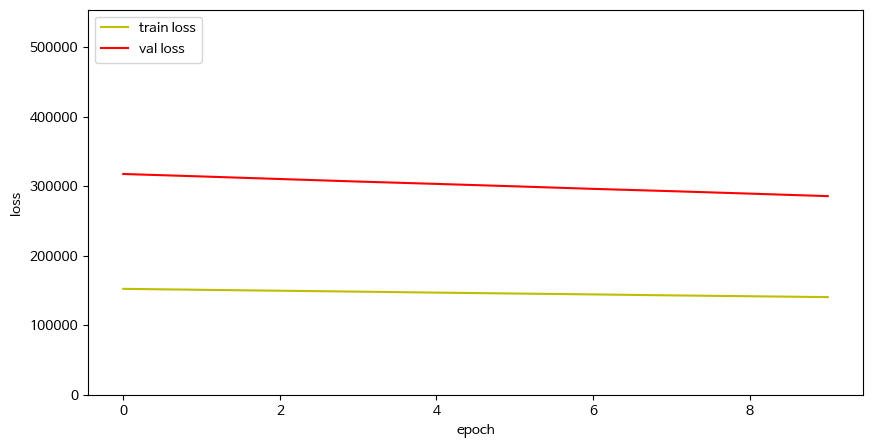

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 553888.2500]) # 값을 반영하여 변경 ★★★★★

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차

loss_ax.legend(loc='upper left') # 오차 레이블 위치

plt.show()
# train loss: 하강하면 훈련이 정상적으로 진행되고 있음
# val loss: 하강하면 훈련되지 않은 데이터를 대상으로 한 테스트도 정상적으로 진행됨.

In [20]:
# 데이터: 훈련, 검증, 테스트로 분할을 권장
# train loss, val loss가 하강한다는 것은 X를가지고 Y를 예측하는데 있어서
# 점점 오차가 줄어든다는 것임

# 테스트 데이터 준비, 훈련/검증에 사용하지 않은 데이터
x = np.array([50, 120, 140, 160, 250]) # 1차원 배열
print(x.shape) # (5,)
print('-' * 30)

p = model.predict(x) # 모델 사용, 2차원 배열
print(type(p))
print(p.shape) # (5, 1): 데이터 입력 건수가 5건이고 출력 데이터 갯수가 1개임
print(p)

(5,)
------------------------------
1/1 [==============================] - 0s 93ms/step
<class 'numpy.ndarray'>
(5, 1)
[[ 9.776721]
 [23.244673]
 [27.092659]
 [30.940645]
 [48.25658 ]]


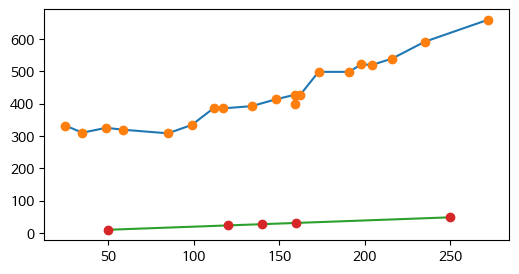

In [21]:
x_train = ds[:, 0]
y_train = ds[:, 1]
plt.plot(x_train, y_train)      # 기본 데이터 선 그래프
plt.plot(x_train, y_train, 'o') # 기본 데이터 마커
plt.plot(x, p)        # [50, 120, 140, 160, 250] 예측 선그래프
plt.plot(x, p, 'o')   # [50, 120, 140, 160, 250] 예측 마커
plt.show()

### 뉴런(노드)을 3 사용한 경우 

In [22]:
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

model = Sequential()
# model.add(Dense(2, input_dim=1, activation='linear', name='layer1'))
model.add(Dense(100, input_dim=1, activation='linear', name='layer1'))
model.add(Dense(1, activation='linear', name='layer2'))
model.compile(optimizer='adam', loss='mse')
model.summary()
hist = model.fit(x_train, y_train, validation_split=0.2, shuffle=True,
                 epochs=10, batch_size=1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 100)               200       
                                                                 
 layer2 (Dense)              (None, 1)                 101       
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
16/16 [==============================] - 1s 20ms/step - loss: 148070.9375 - val_loss: 261659.2812
Epoch 2/10
16/16 [==============================] - 0s 5ms/step - loss: 117131.1797 - val_loss: 190975.2812
Epoch 3/10
16/16 [==============================] - 0s 5ms/step - loss: 91851.1562 - val_loss: 129482.5000
Epoch 4/10
16/16 [==============================] - 0s 5ms/step - loss: 70100.7266 - val_loss: 80149.8047
Epoch 5/10
16/16 [====

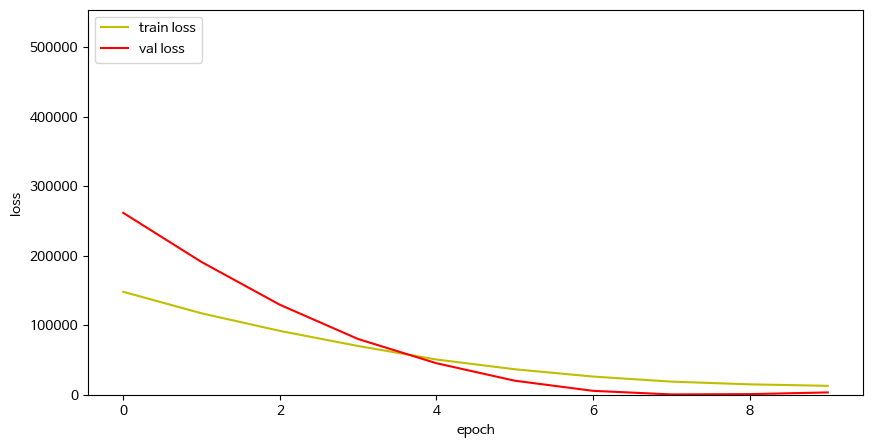

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 553888.2500]) # 값을 반영하여 변경 ★★★★★

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차

loss_ax.legend(loc='upper left') # 오차 레이블 위치

plt.show()
# train loss: 하강하면 훈련이 정상적으로 진행되고 있음
# val loss: 하강하면 훈련되지 않은 데이터를 대상으로 한 테스트도 정상적으로 진행됨.

In [24]:
# 데이터: 훈련, 검증, 테스트로 분할을 권장
# train loss, val loss가 하강한다는 것은 X를가지고 Y를 예측하는데 있어서
# 점점 오차가 줄어든다는 것임

# 테스트 데이터 준비, 훈련/검증에 사용하지 않은 데이터
x = np.array([50, 120, 140, 160, 250]) # 1차원 배열
print(x.shape) # (5,)
print('-' * 30)

p = model.predict(x) # 모델 사용, 2차원 배열
print(type(p))
print(p.shape) # (5, 1): 데이터 입력 건수가 5건이고 출력 데이터 갯수가 1개임
print(p)

(5,)
------------------------------
1/1 [==============================] - 0s 131ms/step
<class 'numpy.ndarray'>
(5, 1)
[[138.16516]
 [328.44153]
 [382.8062 ]
 [437.17087]
 [681.812  ]]


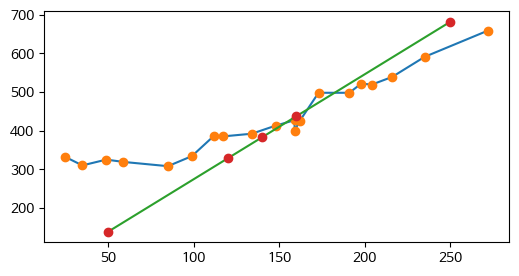

In [25]:
x_train = ds[:, 0]
y_train = ds[:, 1]
plt.plot(x_train, y_train)      # 기본 데이터 선 그래프
plt.plot(x_train, y_train, 'o') # 기본 데이터 마커
plt.plot(x, p)        # [50, 120, 140, 160, 250] 예측 선그래프
plt.plot(x, p, 'o')   # [50, 120, 140, 160, 250] 예측 마커
plt.show()

In [26]:
model.save('./Click.h5') # h5 확장자 변경 불가능

In [27]:
model = load_model('./Click.h5')

In [28]:
x = np.array([50, 120, 140, 160, 250])
print(x)

[ 50 120 140 160 250]


In [29]:
p = model.predict(x)
print(p.shape) # 데이터 5건, 출력 하나의 숫자
print(type(p))
print(p)

1/1 [==============================] - 0s 73ms/step
(5, 1)
<class 'numpy.ndarray'>
[[138.16516]
 [328.44153]
 [382.8062 ]
 [437.17087]
 [681.812  ]]
